## Семинар 1 "Полносвязные нейронные сети"

ФИО: Пронин Сергей Юрьевич

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


In [3]:
class Linear:
    def __init__(self, input_size, output_size, init_loc=0.0, init_scale=0.1):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''        
        self._input_size = input_size
        self._output_size = output_size
        self._weights = np.random.normal(loc=init_loc, scale=init_scale, size=(input_size, output_size))
        
    
    def _check_X(self, X):
        if X.shape[1] != self._input_size:
            raise("X has %d features but linear layer has input size %d" % (X.shape[1], 
                                                                               self._input_size))
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #self._check_X(X)
        self._X = X.copy()
        return np.dot(X, self._weights)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self._dLdw = np.dot(self._X.T, dLdy)
        return np.dot(dLdy, self._weights.T)
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        self._weights -= learning_rate * self._dLdw

### Часть 2: Сигмоида

In [4]:
class Sigmoid:
    def __init__(self):
        pass
    
    def _sigmoid(self, X):
        return 1. / (1. + np.exp(-X))
    
    def _sigmoid_derivative(self, X):
        return self._sigmoid(X) * (1.0 - self._sigmoid(X))
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self._X = X.copy()
        return self._sigmoid(X)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy * self._sigmoid_derivative(self._X)
    
    def step(self, learning_rate):
        pass

### Часть 3: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [5]:
import pandas as pd

In [50]:
X = np.eye(5)
X[0,0] = 5
print np.max(X, axis=0)
print X - np.max(X, axis=1)

[ 5.  1.  1.  1.  1.]
[[ 0. -1. -1. -1. -1.]
 [-5.  0. -1. -1. -1.]
 [-5. -1.  0. -1. -1.]
 [-5. -1. -1.  0. -1.]
 [-5. -1. -1. -1.  0.]]


In [6]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #self._NLLS = []
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        y is np.array of size (N), contains correct labels
        '''
        # TODO: do log-sum-exp trick!!!
        
        self._y_mat = pd.get_dummies(y).values.astype(bool)
        a = np.max(X)
        self._p = np.exp(X)
        self._p = self._p / self._p.sum(axis=1, keepdims=True) #TODO: check this shit
        #self._NLLS.append(np.mean(-np.log(self._p[self._y_mat])))
        NLL = np.sum(-np.log(self._p[self._y_mat]))
        return NLL
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        dLdx = self._p
        dLdx[self._y_mat] -= 1.0
        return dLdx        

### Часть 4, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [7]:
# assume that modules is a list of layers or other neural networks
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self._modules = modules
    
    def forward(self, X):
        tmp = X.copy()
        for module in self._modules:
            tmp = module.forward(tmp)
        return tmp
            
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function or straightforward neural network or module
        '''
        tmp = dLdy.copy()
        for module in reversed(self._modules):
            tmp = module.backward(tmp)
        return tmp
    
    def step(self, learning_rate):
        for module in modules:
            module.step(learning_rate)

In [8]:
class NeuralNetworkFitter:
    def __init__(self, neural_network, loss_func=NLLLoss(), track_loss=True, num_epoch=500, learning_rate=0.01):
        self._neural_network = neural_network
        self._loss_func = loss_func
        self._track_loss = track_loss
        if track_loss:
            self._losses = []
        else:
            self._losses = None
        self._num_epoch = num_epoch
        self._learning_rate = learning_rate
    
    def fit(self, X, y):
        for epoch in xrange(self._num_epoch):
            tmp = self._neural_network.forward(X)
            loss = self._loss_func.forward(tmp, y)
            if self._track_loss:
                self._losses.append(loss)
            tmp = self._loss_func.backward()
            self._neural_network.backward(tmp)
            self._neural_network.step(self._learning_rate)
        return self

### Часть 5, обучение на простых данных

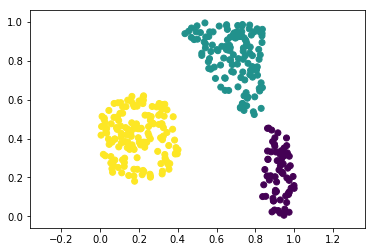

In [9]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.01). 
2. Нарисуйте график сходимости (изменение NLL со временем).
3. Нарисуйте разделяющую поверхность

Отличная визуализация: http://playground.tensorflow.org/

In [12]:
modules = [Linear(2,10), Sigmoid(), Linear(10,10), Sigmoid(), Linear(10,3)]
nn = NeuralNetwork(modules)
cfg = NeuralNetworkFitter(nn, num_epoch=500, learning_rate=0.01)
cfg.fit(X, y)

<__main__.NeuralNetworkFitter instance at 0x000000000A442708>

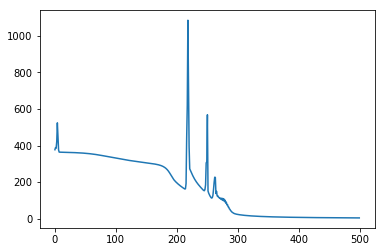

In [13]:
plt.plot(xrange(cfg._num_epoch),cfg._losses)

In [14]:
cfg._loss_func._p

array([[  1.41714341e-07,   1.10582611e-04,  -1.10724326e-04],
       [  8.48361129e-07,   3.65060567e-06,  -4.49896680e-06],
       [  1.33499763e-09,   5.45533894e-08,  -5.58883870e-08],
       ..., 
       [  2.34726306e-09,   1.98554859e-06,  -1.98789586e-06],
       [ -1.04619600e-02,   7.14810672e-03,   3.31385324e-03],
       [  1.37865403e-02,  -1.62390111e-02,   2.45247080e-03]])